## **import**

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

In [32]:
def plot_top_categories_conversion_rate(df, category_col, target_col, top_n=10):
    # 각 범주별로 target_col의 True와 False의 개수를 집계합니다.
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율을 계산합니다.
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택합니다.
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    # 상위 N개 범주의 데이터를 선택합니다.
    top_conversion_rates = conversion_rates.loc[top_categories]

    # 시각화: 상위 N개 범주의 전환율을 바 차트로 시각화합니다.
    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(8, 3))


    plt.title(f'Top {top_n} {category_col} Conversion Rate')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')

    # x축 레이블 회전
    plt.xticks(rotation=45)

    # 범례 설정
    plt.legend(title='Is Converted', labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()



In [74]:
train = pd.read_csv("../Database/train_test_newcol7.csv")
train.drop(['customer_country'], axis= 1 , inplace = True)
train['lead_owner'] = train['lead_owner'].astype('object')

test = pd.read_csv("../Database/test_test_newcol7.csv")
test.drop(['customer_country'], axis= 1 , inplace = True)
test['lead_owner'] = test['lead_owner'].astype('object')

In [75]:
columns_to_encode = ['country','lead_owner', 'business_unit', 'customer_idx', 'customer_type', 'enterprise',
                     'customer_job', 'inquiry_type', 'product_category',
                     'product_subcategory', 'customer_position', 'response_corporate',
                     'expected_timeline', 'business_area', 'business_subarea','ver_win_rate_x_category','historical_existing_cnt_category']

for column in columns_to_encode:
    train[column] = train[column].astype('category')
    test[column] = test[column].astype('category')

In [76]:
from category_encoders import TargetEncoder

# 타겟 인코딩에 사용할 스무딩 값 설정
smoothing_value = 1 # 이 값을 조정하여 스무딩의 정도를 변경할 수 있습니다.

# 타겟 인코더를 각 컬럼에 적용하기 위한 함수
def target_encode(train_df, test_df, columns, target, smoothing):
    encoders = {column: TargetEncoder(smoothing=smoothing) for column in columns}
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()

    for column in columns:
        # 학습 데이터셋에 대해 fit_transform을 사용하여 타겟 인코딩 적용
        train_encoded[column] = encoders[column].fit_transform(train_df[column], target)
        # 테스트 데이터셋에 대해 transform을 사용하여 타겟 인코딩 적용
        test_encoded[column] = encoders[column].transform(test_df[column])

    return train_encoded, test_encoded, encoders

# 인코딩할 컬럼 목록
columns_to_encode = ['business_unit', 'customer_idx', 'customer_type', 'enterprise',
                     'customer_job', 'inquiry_type', 'product_category',
                     'product_subcategory', 'customer_position', 'response_corporate',
                     'expected_timeline', 'business_area', 'business_subarea','ver_win_rate_x_category']

# 타겟 변수 (예: 'target_column')
target_column = 'is_converted'

# train, test 데이터셋에 타겟 인코딩 적용
train_encoded, test_encoded, encoders = target_encode(train, test, columns_to_encode, train[target_column], smoothing=smoothing_value)

# 결과 확인
print("Train encoded shape:", train_encoded.shape)
print("Test encoded shape:", test_encoded.shape)

train = train_encoded
test = test_encoded

Train encoded shape: (59299, 39)
Test encoded shape: (5271, 39)


In [77]:
from category_encoders import TargetEncoder

# 타겟 인코딩에 사용할 스무딩 값 설정
smoothing_value = 5 # 이 값을 조정하여 스무딩의 정도를 변경할 수 있습니다.

# 타겟 인코더를 각 컬럼에 적용하기 위한 함수
def target_encode(train_df, test_df, columns, target, smoothing):
    encoders = {column: TargetEncoder(smoothing=smoothing) for column in columns}
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()

    for column in columns:
        # 학습 데이터셋에 대해 fit_transform을 사용하여 타겟 인코딩 적용
        train_encoded[column] = encoders[column].fit_transform(train_df[column], target)
        # 테스트 데이터셋에 대해 transform을 사용하여 타겟 인코딩 적용
        test_encoded[column] = encoders[column].transform(test_df[column])

    return train_encoded, test_encoded, encoders

# 인코딩할 컬럼 목록
columns_to_encode = ['country','lead_owner','historical_existing_cnt_category']

# 타겟 변수 (예: 'target_column')
target_column = 'is_converted'

# train, test 데이터셋에 타겟 인코딩 적용
train_encoded, test_encoded, encoders = target_encode(train, test, columns_to_encode, train[target_column], smoothing=smoothing_value)

# 결과 확인
print("Train encoded shape:", train_encoded.shape)
print("Test encoded shape:", test_encoded.shape)

train = train_encoded
test = test_encoded

Train encoded shape: (59299, 39)
Test encoded shape: (5271, 39)


In [78]:
from sklearn.preprocessing import StandardScaler

# int형 또는 float형의 컬럼만 선택
numeric_columns = ['historical_existing_cnt','lead_desc_length']

scaler = StandardScaler()

# train 데이터에 대해서 fit과 transform 수행
train_scaled = train.copy()
train_scaled[numeric_columns] = scaler.fit_transform(train[numeric_columns])

# test 데이터에 대해서는 transform만 수행
test_scaled = test.copy()
test_scaled[numeric_columns] = scaler.transform(test[numeric_columns])

train = train_scaled
test = test_scaled

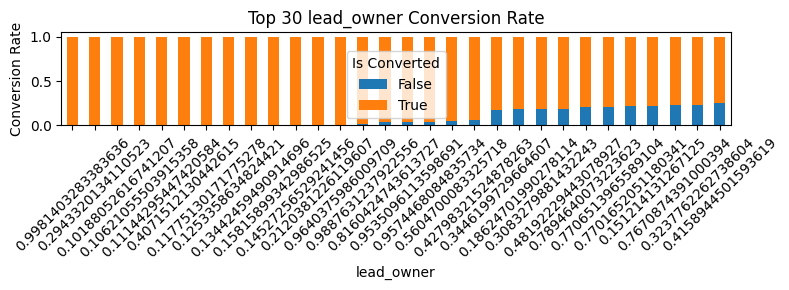

In [79]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['lead_owner']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train, col, 'is_converted', top_n=30)

In [80]:
# 조건에 따라 새로운 컬럼에 1을 할당하는 코드
train['high_customer_type'] = (train['customer_type'] >= 0.98).astype(int)
train['high_customer_idx'] = (train['customer_idx'] >= 0.98).astype(int)
train['high_lead_owner'] = (train['lead_owner'] >= 0.98).astype(int)

train['low_customer_type'] = (train['customer_type'] >= 0.0001).astype(int)
train['low_customer_idx'] = (train['customer_idx'] >= 0.0001).astype(int)
train['low_lead_owner'] = (train['lead_owner'] >= 0.0001).astype(int)

test['high_customer_type'] = (test['customer_type'] >= 0.98).astype(int)
test['high_customer_idx'] = (test['customer_idx'] >= 0.98).astype(int)
test['high_lead_owner'] = (test['lead_owner'] >= 0.98).astype(int)

test['low_customer_type'] = (test['customer_type'] >= 0.0001).astype(int)
test['low_customer_idx'] = (test['customer_idx'] >= 0.0001).astype(int)
test['low_lead_owner'] = (test['lead_owner'] >= 0.0001).astype(int)

In [81]:
train.loc[train['is_converted'] == True, 'is_converted'] = 1
train.loc[train['is_converted'] == False, 'is_converted'] = 0

train['is_converted'] = train['is_converted'].astype(float)


In [82]:
X = train[train.columns.drop('is_converted')]
Y = train['is_converted']

In [83]:
# X와 Y로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [84]:
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)

In [85]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

adasyn = ADASYN(random_state=42)
# SMOTE 오버샘플링 적용
sm = SMOTE(random_state=42)
X_train, y_train = smoteto.fit_resample(X_train, y_train)

In [45]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [103]:
import time
import optuna
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
# XGBoost와 CatBoost 라이브러리를 임포트합니다.
import xgboost as xgb
import catboost as cb
def objective(trial):
    # classifier_name = trial.suggest_categorical('classifier', ['DecisionTree', 'LGBM', 'XGBoost', 'CatBoost'])
    classifier_name = 'CatBoost'
    if classifier_name == 'DecisionTree':
        param = {
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_int('max_features', 1, 30)
        }
        model = DecisionTreeClassifier(**param)
    elif classifier_name == 'LGBM':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 300, 500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 31, 128),
            'max_depth': trial.suggest_int('max_depth', 3, 12),

        }
        model = LGBMClassifier(**param)
    elif classifier_name == 'XGBoost':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        }
        model = xgb.XGBClassifier(**param)
    elif classifier_name == 'CatBoost':
        param = {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 1, 255),
            'loss_function': 'Logloss',
        }
        model = cb.CatBoostClassifier(**param, verbose=False)


    model.fit(X_train, y_train)
    
    test_pred = model.predict(x_test)
    print(sum(test_pred))
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='binary')
    return score

## **catboost,xgboost,dt,lightgbm**

In [104]:
# Optuna Study 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적화 결과 출력
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-15 16:42:25,848] A new study created in memory with name: no-name-20ce6fdf-9229-4040-a320-340526e5ef9c
[I 2024-02-15 16:42:26,253] Trial 0 finished with value: 0.7194127243066885 and parameters: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 18}. Best is trial 0 with value: 0.7194127243066885.


1590.0


[I 2024-02-15 16:42:26,835] Trial 1 finished with value: 0.6795275590551181 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 26}. Best is trial 0 with value: 0.7194127243066885.


2591.0


[I 2024-02-15 16:42:28,015] Trial 2 finished with value: 0.7709154621112572 and parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 30}. Best is trial 2 with value: 0.7709154621112572.


1312.0


[I 2024-02-15 16:42:28,403] Trial 3 finished with value: 0.7523343708314807 and parameters: {'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 6}. Best is trial 2 with value: 0.7709154621112572.


1231.0


[I 2024-02-15 16:42:28,751] Trial 4 finished with value: 0.6598639455782312 and parameters: {'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 9}. Best is trial 2 with value: 0.7709154621112572.


1535.0


[I 2024-02-15 16:42:29,145] Trial 5 finished with value: 0.7605633802816901 and parameters: {'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 11}. Best is trial 2 with value: 0.7709154621112572.


796.0


[I 2024-02-15 16:42:29,604] Trial 6 finished with value: 0.7333608929309632 and parameters: {'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 16}. Best is trial 2 with value: 0.7709154621112572.


2238.0


[I 2024-02-15 16:42:29,912] Trial 7 finished with value: 0.7206375838926175 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': 6}. Best is trial 2 with value: 0.7709154621112572.


920.0


[I 2024-02-15 16:42:30,403] Trial 8 finished with value: 0.6671522214129643 and parameters: {'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 25}. Best is trial 2 with value: 0.7709154621112572.


2569.0


[I 2024-02-15 16:42:30,781] Trial 9 finished with value: 0.696923076923077 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_features': 14}. Best is trial 2 with value: 0.7709154621112572.


2186.0


[I 2024-02-15 16:42:31,765] Trial 10 finished with value: 0.7903225806451613 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 29}. Best is trial 10 with value: 0.7903225806451613.


258.0


[I 2024-02-15 16:42:32,669] Trial 11 finished with value: 0.8 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 30}. Best is trial 11 with value: 0.8.


1935.0


[I 2024-02-15 16:42:33,367] Trial 12 finished with value: 0.7761332099907493 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 22}. Best is trial 11 with value: 0.8.


1534.0


[I 2024-02-15 16:42:34,307] Trial 13 finished with value: 0.7946385830540929 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 30}. Best is trial 11 with value: 0.8.


2359.0


[I 2024-02-15 16:42:35,113] Trial 14 finished with value: 0.7826492537313433 and parameters: {'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 20}. Best is trial 11 with value: 0.8.


2381.0


[I 2024-02-15 16:42:35,895] Trial 15 finished with value: 0.7781410555815039 and parameters: {'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 25}. Best is trial 11 with value: 0.8.


769.0


[I 2024-02-15 16:42:36,669] Trial 16 finished with value: 0.7851580393953276 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': 30}. Best is trial 11 with value: 0.8.


1715.0


[I 2024-02-15 16:42:37,432] Trial 17 finished with value: 0.7656320287899235 and parameters: {'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': 22}. Best is trial 11 with value: 0.8.


1354.0


[I 2024-02-15 16:42:38,302] Trial 18 finished with value: 0.7802303262955854 and parameters: {'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 27}. Best is trial 11 with value: 0.8.


1793.0


[I 2024-02-15 16:42:38,988] Trial 19 finished with value: 0.772748056698674 and parameters: {'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 23}. Best is trial 11 with value: 0.8.


2143.0


[I 2024-02-15 16:42:39,712] Trial 20 finished with value: 0.7856810785681079 and parameters: {'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 28}. Best is trial 11 with value: 0.8.
[I 2024-02-15 16:42:39,901] Trial 21 finished with value: 0.5990302126072361 and parameters: {'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 1}. Best is trial 11 with value: 0.8.


1266.0
2078.0


[I 2024-02-15 16:42:40,752] Trial 22 finished with value: 0.7897727272727273 and parameters: {'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 30}. Best is trial 11 with value: 0.8.


2081.0


[I 2024-02-15 16:42:41,571] Trial 23 finished with value: 0.7765466297322253 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 28}. Best is trial 11 with value: 0.8.


362.0


[I 2024-02-15 16:42:42,337] Trial 24 finished with value: 0.7825670498084292 and parameters: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 24}. Best is trial 11 with value: 0.8.


1195.0


[I 2024-02-15 16:42:43,225] Trial 25 finished with value: 0.7894736842105263 and parameters: {'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 28}. Best is trial 11 with value: 0.8.


1923.0


[I 2024-02-15 16:42:43,876] Trial 26 finished with value: 0.7741626794258373 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 20}. Best is trial 11 with value: 0.8.


1391.0


[I 2024-02-15 16:42:44,866] Trial 27 finished with value: 0.7844455112818051 and parameters: {'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 30}. Best is trial 11 with value: 0.8.


992.0


[I 2024-02-15 16:42:45,572] Trial 28 finished with value: 0.7679633867276888 and parameters: {'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 27}. Best is trial 11 with value: 0.8.


916.0


[I 2024-02-15 16:42:46,074] Trial 29 finished with value: 0.753686036426713 and parameters: {'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 19}. Best is trial 11 with value: 0.8.


2233.0


[I 2024-02-15 16:42:46,486] Trial 30 finished with value: 0.7084180561203741 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 15}. Best is trial 11 with value: 0.8.


1258.0


[I 2024-02-15 16:42:47,313] Trial 31 finished with value: 0.7948226270373921 and parameters: {'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 30}. Best is trial 11 with value: 0.8.


1567.0


[I 2024-02-15 16:42:48,172] Trial 32 finished with value: 0.7827338129496403 and parameters: {'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 26}. Best is trial 11 with value: 0.8.


1620.0


[I 2024-02-15 16:42:49,067] Trial 33 finished with value: 0.788785046728972 and parameters: {'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 29}. Best is trial 11 with value: 0.8.


906.0


[I 2024-02-15 16:42:49,935] Trial 34 finished with value: 0.7888942077549067 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 26}. Best is trial 11 with value: 0.8.


2214.0


[I 2024-02-15 16:42:50,546] Trial 35 finished with value: 0.6879939781708694 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 30}. Best is trial 11 with value: 0.8.


2689.0


[I 2024-02-15 16:42:51,414] Trial 36 finished with value: 0.777211672070403 and parameters: {'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 28}. Best is trial 11 with value: 0.8.


1619.0


[I 2024-02-15 16:42:52,203] Trial 37 finished with value: 0.7747914735866543 and parameters: {'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 24}. Best is trial 11 with value: 0.8.


2106.0


[I 2024-02-15 16:42:52,757] Trial 38 finished with value: 0.7789473684210526 and parameters: {'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 17}. Best is trial 11 with value: 0.8.


938.0


[I 2024-02-15 16:42:53,221] Trial 39 finished with value: 0.7246753246753247 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 12}. Best is trial 11 with value: 0.8.


1697.0


[I 2024-02-15 16:42:54,021] Trial 40 finished with value: 0.7846663511594889 and parameters: {'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 26}. Best is trial 11 with value: 0.8.


953.0


[I 2024-02-15 16:42:54,978] Trial 41 finished with value: 0.7901468498342018 and parameters: {'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 30}. Best is trial 11 with value: 0.8.


1562.0


[I 2024-02-15 16:42:55,979] Trial 42 finished with value: 0.7858490566037736 and parameters: {'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 29}. Best is trial 11 with value: 0.8.


2224.0


[I 2024-02-15 16:42:56,973] Trial 43 finished with value: 0.7796451914098973 and parameters: {'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 29}. Best is trial 11 with value: 0.8.


1040.0


[I 2024-02-15 16:42:57,419] Trial 44 finished with value: 0.6791226645004061 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 27}. Best is trial 11 with value: 0.8.


2808.0


[I 2024-02-15 16:42:58,451] Trial 45 finished with value: 0.7786116322701688 and parameters: {'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 30}. Best is trial 11 with value: 0.8.


1961.0


[I 2024-02-15 16:42:59,117] Trial 46 finished with value: 0.7589650476622787 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 25}. Best is trial 11 with value: 0.8.


1774.0


[I 2024-02-15 16:42:59,468] Trial 47 finished with value: 0.7537279710799819 and parameters: {'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 6}. Best is trial 11 with value: 0.8.


1312.0


[I 2024-02-15 16:43:00,293] Trial 48 finished with value: 0.7672219720846466 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 21}. Best is trial 11 with value: 0.8.


1817.0


[I 2024-02-15 16:43:00,982] Trial 49 finished with value: 0.688115064345193 and parameters: {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 27}. Best is trial 11 with value: 0.8.


896.0
Number of finished trials: 50
Best trial: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 30}


In [90]:
model_xgb = xgb.XGBClassifier(random_state=42,
                              max_depth=8,
                              n_estimators=293,
                              min_child_weight= 7, 
                              subsample= 0.9105470510211687, 
                              colsample_bytree= 0.6106420516903334,
                              learning_rate=0.11721096762426182)  # 0.889783305005426

model_xgb.fit(X_train, y_train)
test_pred = model_xgb.predict(x_test)
print(sum(test_pred))  # True로 예측된 개수

y_pred_xgb = model_xgb.predict(X_test)
# 정확도 및 F1 점수 계산
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGB Accuracy: {accuracy_xgb}")
print(f1_score(y_test, y_pred_xgb, average='binary'))


1980
XGB Accuracy: 0.972681281618887
0.838


In [ ]:
from lightgbm import LGBMClassifier
# LightGBM 모델 생성
model_lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=494,
    learning_rate= 0.03253797176663715,
    num_leaves=117,
    max_depth=6
)

# 모델 학습
model_lgbm.fit(X_train, y_train)

test_pred = model_lgbm.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수


# 예측
y_pred_lgbm = model_lgbm.predict(X_test)

# 정확도 및 F1 점수 계산
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"LGBM Accuracy: {accuracy_lgbm}")
print(f1_score(y_test, y_pred_lgbm, average='binary'))

In [101]:
from catboost import CatBoostClassifier

# CatBoost 모델 생성
model_catboost = CatBoostClassifier(
    random_state=42,
    iterations=304, # n_estimators와 비슷합니다.
    learning_rate=0.08048373583394688,
    depth=8 ,# max_depth와 비슷합니다.
    l2_leaf_reg= 1 ,
    border_count = 148,
    
    silent=True # 학습 과정에서 메시지를 출력하지 않습니다.
)

# 모델 학습
model_catboost.fit(X_train, y_train)

test_pred = model_catboost.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수

# 예측
y_pred_catboost = model_catboost.predict(X_test)

# 정확도 및 F1 점수 계산
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Accuracy: {accuracy_catboost}")
print(f1_score(y_test, y_pred_catboost, average='binary'))


1539.0
CatBoost Accuracy: 0.9710792580101181
0.8296075509190264


In [105]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree 모델 생성
model_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth= 20,# 트리의 최대 깊이를 설정합니다.
    min_samples_split= 16,
    min_samples_leaf=1,
    max_features=26
    
)

# 모델 학습
model_dt.fit(X_train, y_train)

# 예측
y_pred_dt = model_dt.predict(X_test)

test_pred = model_dt.predict(x_test)
print(sum(test_pred))

# 정확도 및 F1 점수 계산
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")
print(f1_score(y_test, y_pred_dt, average='binary'))

2160.0
Decision Tree Accuracy: 0.9611298482293423
0.7816200852676457


In [108]:
from sklearn.ensemble import VotingClassifier

# 앙상블을 위한 분류기 리스트 생성
classifiers = [
    ('xgb', model_xgb),
    ('catboost', model_catboost),
    # ('lgbm', model_lgbm),
    ('dt', model_dt)
]

# 여기서 weights는 각 분류기의 투표에 대한 가중치입니다.
# 가중치를 동일하게 설정하거나 성능 기반으로 조정할 수 있습니다.
weights = [2, 1, 1]

# 소프트 투표 기반의 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=classifiers, voting='soft', weights=weights)

# 앙상블 모델 학습
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6106420516903334,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=No...
                                            max_leaves=None, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=293, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000273999707C0>),
                             ('dt',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=26,
                                                     min_samples_split=16,
                                                     random_state=42))],
                 voting='soft', weights=[2, 1, 1])

In [109]:
# 앙상블 모델을 사용한 예측
y_pred_ensemble = ensemble_model.predict(X_test)

test_pred = ensemble_model.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='binary')

print(f"Ensemble Model Accuracy: {accuracy_ensemble}")
print(f"Ensemble Model F1 Score: {f1_ensemble}")

1748.0
Ensemble Model Accuracy: 0.9711635750421586
Ensemble Model F1 Score: 0.8308605341246291


In [110]:
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)

In [111]:
test_pred = model_xgb.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수

# test_pred = model_lgbm.predict(x_test)
# sum(test_pred)

test_pred = model_catboost.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수
# 
test_pred = ensemble_model.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수

# test_pred = model_dt.predict(x_test)
# print(sum(test_pred)) # True로 예측된 개수



1980
1539.0
1748.0


In [115]:
test_pred = ensemble_model.predict(x_test)
print(sum(test_pred)) # True로 예측된 개수

1748.0


In [116]:
# 1을 True로, 0을 False로 변환
test_pred = test_pred.astype(bool)

In [117]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("../Database/submission.csv")
df_sub["is_converted"] = test_pred

In [114]:
df_sub.to_csv("../Codes/submission.csv", index=False)

In [2]:
import pandas as pd
data = pd.read_csv('./submission_0.762.csv')

In [5]:
data['is_converted'].sum()

1748.0